## Attention Cues

In [1]:
import torch
from d2l import torch as d2l

In [2]:
# 注意力可视化
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_titles(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

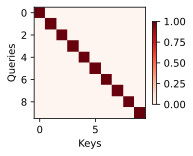

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## Nadaraya-Watson Kernel

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

简单起见，考虑下面这个回归问题：
给定的成对的“输入－输出”数据集
$\{(x_1, y_1), \ldots, (x_n, y_n)\}$，
如何学习$f$来预测任意新输入$x$的输出$\hat{y} = f(x)$？

根据下面的非线性函数生成一个人工数据集，
其中加入的噪声项为$\epsilon$：

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

其中$\epsilon$服从均值为$0$和标准差为$0.5$的正态分布。
在这里生成了$50$个训练样本和$50$个测试样本。
为了更好地可视化之后的注意力模式，需要将训练样本进行排序。


In [5]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)  # _为索引

In [6]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

In [7]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

基于平均汇聚来计算所有训练样本输出值的平均值：

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$

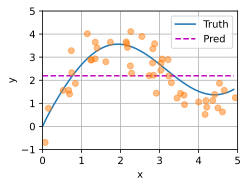

In [8]:
# 平均汇聚
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

根据输入的位置对输出$y_i$进行加权：
$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$
其中$K$是*核*（kernel）。
上式所描述的估计器被称为
*Nadaraya-Watson核回归*（Nadaraya-Watson kernel regression）。
这里不会深入讨论核函数的细节，
但受此启发，
我们可以从之前的注意力机制框架的角度
重写上式，
成为一个更加通用的*注意力汇聚*（attention pooling）公式：
$$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$$
其中$x$是查询，$(x_i, y_i)$是键值对。

为了更好地理解注意力汇聚，
下面考虑一个`*高斯核*`（Gaussian kernel），其定义为：

$$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).$$

将高斯核代入前两式可以得到：

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$

在上式中，
如果一个键$x_i$越是接近给定的查询$x$，
那么分配给这个键对应值$y_i$的注意力权重就会越大，
也就“获得了更多的注意力”。

值得注意的是，Nadaraya-Watson核回归是一个非参数模型。
因此，上式是
*非参数的注意力汇聚*（nonparametric attention pooling）模型。
接下来，我们将基于这个非参数的注意力汇聚模型来绘制预测结果。
从绘制的结果会发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。

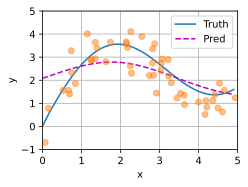

In [9]:
# 非参数注意力汇聚
# x_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
x_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(x_repeat - x_train)**2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

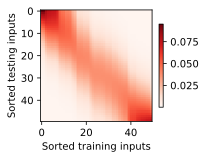

In [10]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

非参数的Nadaraya-Watson核回归具有*一致性*（consistency）的优点：
如果有足够的数据，此模型会收敛到最优结果。
尽管如此，我们还是可以轻松地将可学习的参数集成到注意力汇聚中。

例如，与不带参数略有不同，
在下面的查询$x$和键$x_i$之间的距离乘以可学习参数$w$：

$$\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$

为了更有效地计算小批量数据的注意力，
我们可以利用深度学习开发框架中提供的批量矩阵乘法。

假设第一个小批量数据包含$n$个矩阵$\mathbf{X}_1,\ldots, \mathbf{X}_n$，
形状为$a\times b$，
第二个小批量包含$n$个矩阵$\mathbf{Y}_1, \ldots, \mathbf{Y}_n$，
形状为$b\times c$。
它们的批量矩阵乘法得到$n$个矩阵
$\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$，
形状为$a\times c$。
因此，**假定两个张量的形状分别是$(n,a,b)$和$(n,b,c)$，
它们的批量矩阵乘法输出的形状为$(n,a,c)$**。

In [11]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [12]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
print(weights.unsqueeze(1))
print(values.unsqueeze(-1))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]],

        [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]]])
tensor([[[ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 7.],
         [ 8.],
         [ 9.]],

        [[10.],
         [11.],
         [12.],
         [13.],
         [14.],
         [15.],
         [16.],
         [17.],
         [18.],
         [19.]]])


tensor([[[ 4.5000]],

        [[14.5000]]])

In [13]:
# 定义模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [14]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
print(X_tile)
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
print(Y_tile)
# keys的形状:(n_train, n_train - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
print(keys)
# values的形状:(n_train, n_train - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
print(values)

tensor([[0.0655, 0.1512, 0.5286,  ..., 4.6120, 4.6562, 4.9413],
        [0.0655, 0.1512, 0.5286,  ..., 4.6120, 4.6562, 4.9413],
        [0.0655, 0.1512, 0.5286,  ..., 4.6120, 4.6562, 4.9413],
        ...,
        [0.0655, 0.1512, 0.5286,  ..., 4.6120, 4.6562, 4.9413],
        [0.0655, 0.1512, 0.5286,  ..., 4.6120, 4.6562, 4.9413],
        [0.0655, 0.1512, 0.5286,  ..., 4.6120, 4.6562, 4.9413]])
tensor([[-0.6935,  0.7838,  1.5610,  ...,  0.6292,  1.5626,  1.2404],
        [-0.6935,  0.7838,  1.5610,  ...,  0.6292,  1.5626,  1.2404],
        [-0.6935,  0.7838,  1.5610,  ...,  0.6292,  1.5626,  1.2404],
        ...,
        [-0.6935,  0.7838,  1.5610,  ...,  0.6292,  1.5626,  1.2404],
        [-0.6935,  0.7838,  1.5610,  ...,  0.6292,  1.5626,  1.2404],
        [-0.6935,  0.7838,  1.5610,  ...,  0.6292,  1.5626,  1.2404]])
tensor([[0.1512, 0.5286, 0.6676,  ..., 4.6120, 4.6562, 4.9413],
        [0.0655, 0.5286, 0.6676,  ..., 4.6120, 4.6562, 4.9413],
        [0.0655, 0.1512, 0.6676,  ..., 4

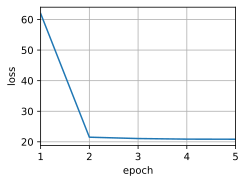

In [15]:
# Train
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

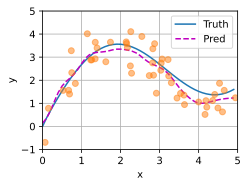

In [16]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

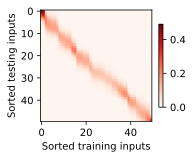

In [17]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

### More samples(no improvement)

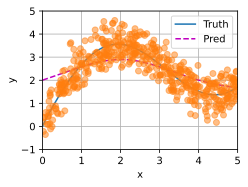

In [18]:
n_train_more = 500
x_train_more, _ = torch.sort(torch.rand(n_train_more) * 5)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train_more = f(x_train_more) + torch.normal(0.0, 0.5, (n_train_more,))
x_test_more = torch.arange(0, 5, 0.01)
y_truth_more = f(x_test_more)

def plot_kernel_regv_more(y_hat_more):
    d2l.plot(x_test_more, [y_truth_more, y_hat_more], 'x', 'y', 
             legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train_more, y_train_more, 'o', alpha=0.5)

x_repeat_more = x_test_more.repeat_interleave(n_train_more).reshape((-1, n_train_more))
attention_weights_more = nn.functional.softmax(-(x_repeat_more - x_train_more)**2 / 2, dim=1)
y_hat_more = torch.matmul(attention_weights_more, y_train_more)
plot_kernel_regv_more(y_hat_more)

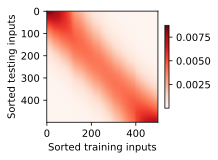

In [19]:
d2l.show_heatmaps(attention_weights_more.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

### Add HyperParameter in non-parameter-kernel

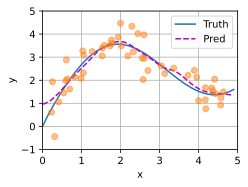

In [20]:
n_train_test = 50
x_train_test, _ = torch.sort(torch.rand(n_train_test) * 5)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train_test = f(x_train_test) + torch.normal(0.0, 0.5, (n_train_test,))
x_test_test = torch.arange(0, 5, 0.1)
y_truth_test = f(x_test_test)

def plot_kernel_regv_more(y_hat_test):
    d2l.plot(x_test_test, [y_truth_test, y_hat_test], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train_test, y_train_test, 'o', alpha=0.5);

X_repeat_test = x_test_test.repeat_interleave(n_train_test).reshape((-1, n_train_test))
attention_weights_test = nn.functional.softmax(-((X_repeat_test - x_train_test)*net.w.detach().numpy())**2 / 2, dim=1)  # 加入训练好的权重
y_hat_test = torch.matmul(attention_weights_test, y_train_test)
plot_kernel_regv_more(y_hat_test)


### New Model

In [21]:
# 定义模型
class NWKernelRegressiontest(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys))**2 / 2 * self.w, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

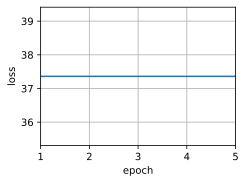

In [22]:
# Train
net_test = NWKernelRegressiontest()
loss_test = nn.MSELoss(reduction='none')
trainer_test = torch.optim.SGD(net.parameters(), lr=0.5)
animator_test = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer_test.zero_grad()
    l = loss_test(net_test(x_train, keys, values), y_train)
    l.sum().backward()
    trainer_test.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator_test.add(epoch + 1, float(l.sum()))

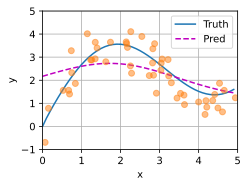

In [23]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net_test(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

In [24]:
print(net_test.w)

Parameter containing:
tensor([0.8357], requires_grad=True)


[参考答案](https://blog.csdn.net/qq_43941037/article/details/134014757)

## Attention-Scoring

### Hiding Softmax

用数学语言描述，假设有一个查询
$\mathbf{q} \in \mathbb{R}^q$和
$m$个“键－值”对
$(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$，
其中$\mathbf{k}_i \in \mathbb{R}^k$，$\mathbf{v}_i \in \mathbb{R}^v$。
注意力汇聚函数$f$就被表示成值的加权和：

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$

其中查询$\mathbf{q}$和键$\mathbf{k}_i$的注意力权重（标量）
是通过注意力评分函数$a$将两个向量映射成标量，
再经过softmax运算得到的：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$

选择不同的注意力评分函数$a$会导致不同的注意力汇聚操作。

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或者2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.6027, 0.3973, 0.0000, 0.0000],
         [0.5749, 0.4251, 0.0000, 0.0000]],

        [[0.3052, 0.3675, 0.3273, 0.0000],
         [0.5100, 0.2721, 0.2180, 0.0000]]])

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3004, 0.4501, 0.2495, 0.0000]],

        [[0.4350, 0.5650, 0.0000, 0.0000],
         [0.2452, 0.1851, 0.2434, 0.3262]]])

### Additive Attention

一般来说，当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。
给定查询$\mathbf{q} \in \mathbb{R}^q$和
键$\mathbf{k} \in \mathbb{R}^k$，
*加性注意力*（additive attention）的评分函数为

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$

其中可学习的参数是$\mathbf W_q\in\mathbb R^{h\times q}$、
$\mathbf W_k\in\mathbb R^{h\times k}$和
$\mathbf w_v\in\mathbb R^{h}$。
如上式所示，
将查询和键连结起来后输入到一个多层感知机（MLP）中，
感知机包含一个隐藏层，其隐藏单元数是一个超参数$h$。
通过使用$\tanh$作为激活函数，并且禁用偏置项。

In [5]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [6]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

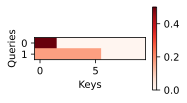

In [7]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### Scaled Dot-Production Attention

使用点积可以得到计算效率更高的评分函数，
但是点积操作要求查询和键具有相同的长度$d$。
假设查询和键的所有元素都是独立的随机变量，
并且都满足零均值和单位方差，
那么两个向量的点积的均值为$0$，方差为$d$。
为确保无论向量长度如何，
点积的方差在不考虑向量长度的情况下仍然是$1$，
我们再将点积除以$\sqrt{d}$，
则*缩放点积注意力*（scaled dot-product attention）评分函数为：

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}.$$

在实践中，我们通常从小批量的角度来考虑提高效率，
例如基于$n$个查询和$m$个键－值对计算注意力，
其中查询和键的长度为$d$，值的长度为$v$。
查询$\mathbf Q\in\mathbb R^{n\times d}$、
键$\mathbf K\in\mathbb R^{m\times d}$和
值$\mathbf V\in\mathbb R^{m\times v}$的缩放点积注意力是：

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$

In [8]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs) -> None:
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    # queries的形状：(batch_size,查询的个数，d)
    # keys的形状：(batch_size,“键－值”对的个数，d)
    # values的形状：(batch_size,“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size,)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [9]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

In [10]:
attention(queries, keys, values, valid_lens).shape

torch.Size([2, 1, 4])

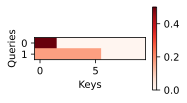

In [11]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### Change the Keys

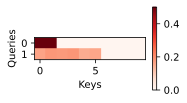

In [12]:
queries_new, keys_rand = torch.normal(0, 1, (2, 1, 2)), torch.rand((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention_rand = AdditiveAttention(key_size=2, query_size=2, num_hiddens=8,
                              dropout=0.1)
attention_rand.eval()
attention_rand(queries_new, keys_rand, values, valid_lens)

d2l.show_heatmaps(attention_rand.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')


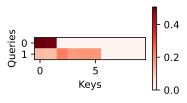

In [13]:
attention_rand = DotProductAttention(dropout=0.5)
attention_rand.eval()
attention_rand(queries_new, keys_rand, values, valid_lens)

d2l.show_heatmaps(attention_rand.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')


[参考答案](https://blog.csdn.net/qq_43941037/article/details/134040163)

## Seq2Seq Attention(Bahdanau)

In [14]:
import torch
from torch import nn
from d2l import torch as d2l

In [15]:
class AttentionDecoder(d2l.Decoder):
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [17]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, 
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, 
                          num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为(num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [18]:
# Test
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size, num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

In [22]:
state

[tensor([[[ 0.0164,  0.0754,  0.0028, -0.1437, -0.0278,  0.1068,  0.1255,
            0.1465, -0.1878,  0.1211, -0.0800,  0.0584, -0.0096, -0.0766,
           -0.0066,  0.1091],
          [ 0.0129,  0.1419,  0.0076, -0.2638, -0.0584,  0.1183,  0.1928,
            0.2359, -0.3077,  0.2026, -0.1481,  0.1053, -0.0290, -0.1227,
            0.0012,  0.0709],
          [ 0.0051,  0.1926,  0.0155, -0.3507, -0.0821,  0.0984,  0.2291,
            0.2895, -0.3855,  0.2589, -0.1983,  0.1383, -0.0507, -0.1371,
            0.0110, -0.0066],
          [-0.0009,  0.2288,  0.0236, -0.4117, -0.0975,  0.0724,  0.2480,
            0.3212, -0.4370,  0.2977, -0.2335,  0.1605, -0.0716, -0.1343,
            0.0189, -0.0781],
          [-0.0043,  0.2537,  0.0300, -0.4546, -0.1062,  0.0493,  0.2568,
            0.3394, -0.4710,  0.3244, -0.2576,  0.1759, -0.0900, -0.1254,
            0.0241, -0.1309],
          [-0.0058,  0.2706,  0.0343, -0.4850, -0.1103,  0.0311,  0.2603,
            0.3496, -0.4932,  0.3428

loss 0.019, 2153.4 tokens/sec on cuda:0


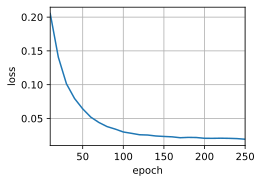

In [23]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [24]:
engs = ['go .', 'i lost .', "he's calm .", "i'm home ."]
fras = ['va !', "j'ai perdu .", 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True
    )
    print(f'{eng} => {translation}, bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est bon ., bleu 0.658
i'm home . => je suis chez moi ., bleu 1.000


In [26]:
dec_attention_weight_seq

[[tensor([[[0.2637, 0.3025, 0.1998, 0.2340, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)],
 [tensor([[[0.0167, 0.1644, 0.3617, 0.4573, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)],
 [tensor([[[0.0146, 0.1044, 0.3472, 0.5338, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)],
 [tensor([[[0.0703, 0.3164, 0.3141, 0.2992, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)],
 [tensor([[[0.0198, 0.1525, 0.3183, 0.5093, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)],
 [tensor([[[0.0528, 0.1857, 0.3611, 0.4004, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)]]

In [27]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape(
    (1, 1, -1, num_steps)
)

In [29]:
attention_weights, attention_weights.shape

(tensor([[[[0.2637, 0.3025, 0.1998, 0.2340, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000],
           [0.0167, 0.1644, 0.3617, 0.4573, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000],
           [0.0146, 0.1044, 0.3472, 0.5338, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000],
           [0.0703, 0.3164, 0.3141, 0.2992, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000],
           [0.0198, 0.1525, 0.3183, 0.5093, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000],
           [0.0528, 0.1857, 0.3611, 0.4004, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]]], device='cuda:0', grad_fn=<ViewBackward0>),
 torch.Size([1, 1, 6, 10]))

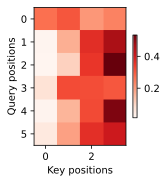

In [32]:
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

### LSTM Replacement

In [42]:
class Seq2SeqEncoder_LSTM(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder_LSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, num_hiddens, num_layers,  # 更换为 LSTM
                          dropout=dropout)
        
    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)
        output, state = self.lstm(X)
        return output, state

In [38]:
class Seq2SeqAttentionDecoder_LSTM(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, 
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder_LSTM, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size + num_hiddens, num_hiddens, 
                          num_layers, dropout=dropout)  # 替换成LSTM
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            ##########################################################
            # 解码器最终隐藏层的上一个输出添加querry个数的维度后作为querry
            query = torch.unsqueeze(hidden_state[-1][0], dim=1)  
            ##########################################################
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为(num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.021, 1846.1 tokens/sec on cuda:0


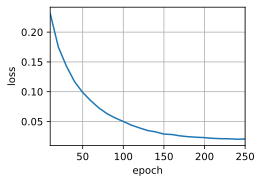

In [44]:
encoder_LSTM = Seq2SeqEncoder_LSTM(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder_LSTM = Seq2SeqAttentionDecoder_LSTM(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net_LSTM = d2l.EncoderDecoder(encoder_LSTM, decoder_LSTM)
d2l.train_seq2seq(net_LSTM, train_iter, lr, num_epochs, tgt_vocab, device)

In [45]:
engs = ['go .', 'i lost .', "he's calm .", "i'm home ."]
fras = ['va !', "j'ai perdu .", 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation_LSTM, dec_attention_weight_seq_LSTM = d2l.predict_seq2seq(
        net_LSTM, eng, src_vocab, tgt_vocab, num_steps, device, True
    )
    print(f'{eng} => {translation_LSTM}, bleu {d2l.bleu(translation_LSTM, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => soyez calme !, bleu 0.000
i'm home . => je suis chez moi ., bleu 1.000


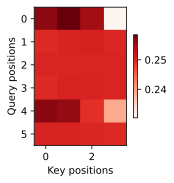

In [46]:
attention_weights_LSTM = torch.cat([step[0][0][0] for step in dec_attention_weight_seq_LSTM], 0).reshape((1, 1, -1, num_steps))
d2l.show_heatmaps(attention_weights_LSTM[:, :, :, :len(engs[-1].split()) + 1].cpu(),
                  xlabel='Key positions', ylabel='Query positions')

### Dot-Product Attention Replacement

In [51]:
class Seq2SeqAttentionDecoder_Dot(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder_Dot, self).__init__(**kwargs)
        self.attention = d2l.DotProductAttention(dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, 
                          num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为(num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.020, 2534.8 tokens/sec on cuda:0


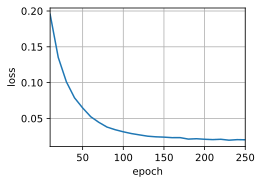

In [52]:
decoder_Dot = Seq2SeqAttentionDecoder_Dot(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net_Dot = d2l.EncoderDecoder(encoder, decoder_Dot)
d2l.train_seq2seq(net_Dot, train_iter, lr, num_epochs, tgt_vocab, device)

In [53]:
engs = ['go .', 'i lost .', "he's calm .", "i'm home ."]
fras = ['va !', "j'ai perdu .", 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation_Dot, dec_attention_weight_seq_Dot = d2l.predict_seq2seq(
        net_Dot, eng, src_vocab, tgt_vocab, num_steps, device, True
    )
    print(f'{eng} => {translation_Dot}, bleu {d2l.bleu(translation_Dot, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est mouillé ., bleu 0.658
i'm home . => je suis chez moi ., bleu 1.000


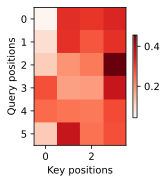

In [54]:
attention_weights_Dot = torch.cat([step[0][0][0] for step in dec_attention_weight_seq_Dot], 0).reshape((1, 1, -1, num_steps))
d2l.show_heatmaps(attention_weights_Dot[:, :, :, :len(engs[-1].split()) + 1].cpu(),
                  xlabel='Key positions', ylabel='Query positions')

[参考答案(部分有误)](https://blog.csdn.net/qq_43941037/article/details/134043136)

## Multihead Attention

在实践中，当给定相同的查询、键和值的集合时，
我们希望模型可以基于相同的注意力机制学习到不同的行为，
然后将不同的行为作为知识组合起来，
捕获序列内各种范围的依赖关系
（例如，短距离依赖和长距离依赖关系）。
因此，允许注意力机制组合使用查询、键和值的不同
*子空间表示*（representation subspaces）可能是有益的。

为此，与其只使用单独一个注意力汇聚，
我们可以用独立学习得到的$h$组不同的
*线性投影*（linear projections）来变换查询、键和值。
然后，这$h$组变换后的查询、键和值将并行地送到注意力汇聚中。
最后，将这$h$个注意力汇聚的输出拼接在一起，
并且通过另一个可以学习的线性投影进行变换，
以产生最终输出。
这种设计被称为*多头注意力*（multihead attention）

在实现多头注意力之前，让我们用数学语言将这个模型形式化地描述出来。
给定查询$\mathbf{q} \in \mathbb{R}^{d_q}$、
键$\mathbf{k} \in \mathbb{R}^{d_k}$和
值$\mathbf{v} \in \mathbb{R}^{d_v}$，
每个注意力头$\mathbf{h}_i$（$i = 1, \ldots, h$）的计算方法为：

$$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},$$

其中，可学习的参数包括
$\mathbf W_i^{(q)}\in\mathbb R^{p_q\times d_q}$、
$\mathbf W_i^{(k)}\in\mathbb R^{p_k\times d_k}$和
$\mathbf W_i^{(v)}\in\mathbb R^{p_v\times d_v}$，
以及代表注意力汇聚的函数$f$。

$f$可以是加性注意力和缩放点积注意力。
多头注意力的输出需要经过另一个线性转换，
它对应着$h$个头连结后的结果，因此其可学习参数是
$\mathbf W_o\in\mathbb R^{p_o\times h p_v}$：

$$\mathbf W_o \begin{bmatrix}\mathbf h_1\\\vdots\\\mathbf h_h\end{bmatrix} \in \mathbb{R}^{p_o}.$$

基于这种设计，每个头都可能会关注输入的不同部分，
可以表示比简单加权平均值更复杂的函数。

In [2]:
import math
import torch
from d2l import torch as d2l
from torch import nn

在实现过程中通常**选择缩放点积注意力作为每一个注意力头**。
为了避免计算代价和参数代价的大幅增长，
我们设定$p_q = p_k = p_v = p_o / h$。
值得注意的是，如果将查询、键和值的线性变换的输出数量设置为
$p_q h = p_k h = p_v h = p_o$，
则可以并行计算$h$个头。
在下面的实现中，$p_o$是通过参数`num_hiddens`指定的。

In [11]:
class MultiheadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiheadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0
            )
        
        # output的形状:(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)


In [13]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1],  num_heads, -1)
    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)
    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数, num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [14]:
num_hiddens, num_heads = 100, 5
attention = MultiheadAttention(num_hiddens, num_hiddens, num_hiddens, 
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiheadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [15]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

### Visualize

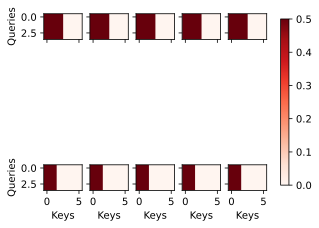

In [16]:
d2l.show_heatmaps(attention.attention.attention_weights.reshape((2, 5, 4, 6)),
                  xlabel='Keys', ylabel='Queries', figsize=(5,5))

## Self-Attention & Positional Encoding

In [17]:
import math
import torch
from torch import nn
from d2l import torch as d2l

给定一个由词元组成的输入序列$\mathbf{x}_1, \ldots, \mathbf{x}_n$，
其中任意$\mathbf{x}_i \in \mathbb{R}^d$（$1 \leq i \leq n$）。
该序列的自注意力输出为一个长度相同的序列
$\mathbf{y}_1, \ldots, \mathbf{y}_n$，其中：

$$\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), \ldots, (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d$$

根据注意力汇聚函数$f$。
下面的代码片段是基于多头注意力对一个张量完成自注意力的计算，
张量的形状为（批量大小，时间步的数目或词元序列的长度，$d$）。
输出与输入的张量形状相同。


In [18]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [19]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

[参考答案](https://blog.csdn.net/qq_43941037/article/details/134052752)

### Comparison between CNN、RNN & Self-Attention 

![比较卷积神经网络（填充词元被忽略）、循环神经网络和自注意力三种架构](./img/cnn-rnn-self-attention.svg)

在处理词元序列时，循环神经网络是逐个的重复地处理词元的，
而自注意力则因为并行计算而放弃了顺序操作。
为了使用序列的顺序信息，通过在输入表示中添加
*位置编码*（positional encoding）来注入绝对的或相对的位置信息。
位置编码可以通过学习得到也可以直接固定得到。
接下来描述的是基于正弦函数和余弦函数的固定位置编码。

假设输入表示$\mathbf{X} \in \mathbb{R}^{n \times d}$
包含一个序列中$n$个词元的$d$维嵌入表示。
位置编码使用相同形状的位置嵌入矩阵
$\mathbf{P} \in \mathbb{R}^{n \times d}$输出$\mathbf{X} + \mathbf{P}$，
矩阵第$i$行、第$2j$列和$2j+1$列上的元素为：

$$\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}$$

乍一看，这种基于三角函数的设计看起来很奇怪。
在解释这个设计之前，让我们先在下面的`PositionalEncoding`类中实现它。

In [21]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len =1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

在位置嵌入矩阵$\mathbf{P}$中，

**行代表词元在序列中的位置，列代表位置编码的不同维度**。

从下面的例子中可以看到位置嵌入矩阵的第$6$列和第$7$列的频率高于第$8$列和第$9$列。
第$6$列和第$7$列之间的偏移量（第$8$列和第$9$列相同）是由于正弦函数和余弦函数的交替。


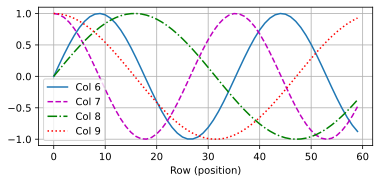

In [22]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, 
         xlabel='Row (position)', figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

为了明白沿着编码维度单调降低的频率与绝对位置信息的关系，
让我们打印出$0, 1, \ldots, 7$的**二进制表示**形式。
正如所看到的，每个数字、每两个数字和每四个数字上的比特值
在第一个最低位、第二个最低位和第三个最低位上分别交替。

In [23]:
for i in range(8):
    print(f'{i}的二进制是：{i:>03b}')

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


在二进制表示中，较高比特位的交替频率低于较低比特位，
与下面的热图所示相似，只是位置编码通过使用三角函数**在编码维度上降低频率**。
由于输出是浮点数，因此此类连续表示比二进制表示法更节省空间。


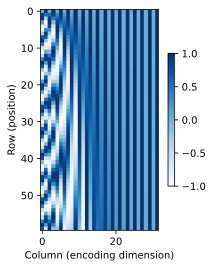

In [24]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

除了捕获绝对位置信息之外，上述的位置编码还允许模型学习得到输入序列中相对位置信息。
这是因为对于任何确定的位置偏移$\delta$，位置$i + \delta$处
的位置编码可以线性投影位置$i$处的位置编码来表示。

这种投影的数学解释是，令$\omega_j = 1/10000^{2j/d}$，
对于任何确定的位置偏移$\delta$，

$$\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}$$

中的任何一对
$(p_{i, 2j}, p_{i, 2j+1})$都可以线性投影到
$(p_{i+\delta, 2j}, p_{i+\delta, 2j+1})$：

$$\begin{aligned}
&\begin{bmatrix} \cos(\delta \omega_j) & \sin(\delta \omega_j) \\  -\sin(\delta \omega_j) & \cos(\delta \omega_j) \\ \end{bmatrix}
\begin{bmatrix} p_{i, 2j} \\  p_{i, 2j+1} \\ \end{bmatrix}\\
=&\begin{bmatrix} \cos(\delta \omega_j) \sin(i \omega_j) + \sin(\delta \omega_j) \cos(i \omega_j) \\  -\sin(\delta \omega_j) \sin(i \omega_j) + \cos(\delta \omega_j) \cos(i \omega_j) \\ \end{bmatrix}\\
=&\begin{bmatrix} \sin\left((i+\delta) \omega_j\right) \\  \cos\left((i+\delta) \omega_j\right) \\ \end{bmatrix}\\
=& 
\begin{bmatrix} p_{i+\delta, 2j} \\  p_{i+\delta, 2j+1} \\ \end{bmatrix},
\end{aligned}$$

$2\times 2$投影矩阵不依赖于任何位置的索引$i$。

## Transformer

![transformer架构](./img/transformer.svg)

In [2]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

### Positionwise Feed-Forward Networks

In [3]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                **kwargs):  # 用一个两层的多层感知机进行位置表示变换
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [4]:
# Test
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
a = ffn(torch.ones((2, 3, 4)))
print(a[0])
print(a.shape)

tensor([[-0.5928,  0.6459, -0.0964, -0.5121, -0.1305,  0.5737, -0.3467,  0.1402],
        [-0.5928,  0.6459, -0.0964, -0.5121, -0.1305,  0.5737, -0.3467,  0.1402],
        [-0.5928,  0.6459, -0.0964, -0.5121, -0.1305,  0.5737, -0.3467,  0.1402]],
       grad_fn=<SelectBackward0>)
torch.Size([2, 3, 8])


### Add & Norm

层归一化（Layer Normalization）和批量归一化（Batch Normalization）的机制有所不同：

- 层归一化：它是在每个样本上独立进行的，即对每个样本的输入数据进行归一化。它的目标是使每个样本的输入数据的均值为0，方差为1。层归一化的主要优点是它可以在每个样本上独立进行，因此它不需要在训练过程中计算整个批次的均值和方差。

- 批量归一化：它是在整个批次的数据上进行的，即对整个批次的输入数据进行归一化。它的目标是使整个批次的输入数据的均值为0，方差为1。批量归一化的主要优点是它可以减少内存使用，因为它不需要为每个样本单独存储均值和方差。

层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。

In [5]:
ln = nn.LayerNorm(2)  # 层规范化
bn = nn.BatchNorm1d(2)  # 批量规范化
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [6]:
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs) -> None:
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X) 

In [7]:
# Test
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

### Encoder

In [8]:
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [9]:
# Test
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

下面实现的**Transformer编码器**的代码中，堆叠了`num_layers`个`EncoderBlock`类的实例。由于这里使用的是值范围在$-1$和$1$之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。

In [10]:
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size, 
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 EncoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens, 
                                              num_heads, dropout, use_bias))
            
    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [11]:
# Test
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

### Decoder

In [12]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs) -> None:
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size,
                                                 num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size,
                                                 num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [14]:
# Test
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))

state = [encoder_blk(X, valid_lens), valid_lens, [None]]

decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [18]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, 
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i), 
                                 DecoderBlock(key_size, query_size, value_size, 
                                              num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights

### Train

loss 0.031, 9981.4 tokens/sec on cuda:0


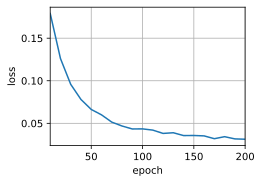

In [22]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4

key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout)

net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

### Predict

In [23]:
engs = ['go .', 'i lost .', "he's calm .", "i'm home ."]
fras = ['va !', "j'ai perdu .", 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True
    )
    print(f'{eng} => {translation}, bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est calme ., bleu 1.000
i'm home . => je suis chez moi ., bleu 1.000


### Visualize

In [26]:
# Encoder
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps))

enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

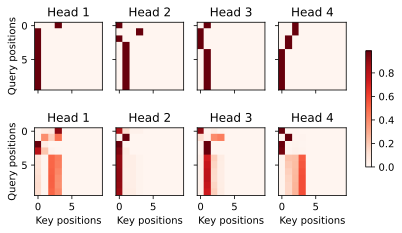

In [27]:
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',
                  ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
                  figsize=(7, 3.5))

**为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作。** 例如用零填充被掩蔽住的注意力权重。值得注意的是，解码器的自注意力权重和“编码器－解码器”的注意力权重都有相同的查询：即以*序列开始词元*（beginning-of-sequence,BOS）打头，再与后续输出的词元共同组成序列。

In [28]:
# Decoder
dec_attention_weights_2d = [head[0].tolist() 
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

在这段代码中，dec_self_attention_weights和dec_inter_attention_weights是两种不同类型的注意力权重。

- dec_self_attention_weights是自注意力权重，它是指在同一个序列中的不同位置之间的注意力。

- dec_inter_attention_weights是交叉注意力权重，它是指在不同的序列之间的注意力。

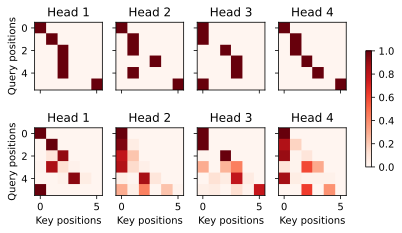

In [29]:
d2l.show_heatmaps(dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
                  xlabel='Key positions', ylabel='Query positions',
                  titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

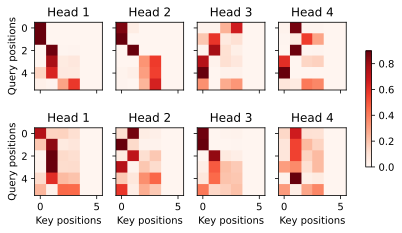

In [32]:
d2l.show_heatmaps(dec_inter_attention_weights[:, :, :, :len(translation.split()) + 1],
                  xlabel='Key positions', ylabel='Query positions',
                  titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

### Deeper Transformer

loss 0.086, 6285.7 tokens/sec on cuda:0


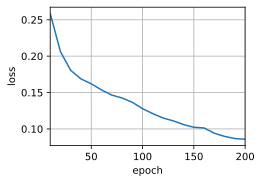

In [33]:
num_hiddens, num_layers_deeper, dropout, batch_size, num_steps = 32, 4, 0.1, 64, 10  # 加深到 4 层
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4  # 还是4头注意力
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder_deeper = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers_deeper, dropout)
decoder_deeper = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers_deeper, dropout)
net_deeper = d2l.EncoderDecoder(encoder_deeper, decoder_deeper)
d2l.train_seq2seq(net_deeper, train_iter, lr, num_epochs, tgt_vocab, device)  # 精度下降

In [41]:
engs = ['go .', 'i lost .', "he's rich .", "i'm home ."]
fras = ['va !', "j'ai perdu .", 'il est riche .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net_deeper, eng, src_vocab, tgt_vocab, num_steps, device, True
    )
    print(f'{eng} => {translation}, bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va le chercher !, bleu 0.000
i lost . => je suis malade ., bleu 0.000
he's rich . => il est <unk> ., bleu 0.658
i'm home . => je suis <unk> ., bleu 0.512


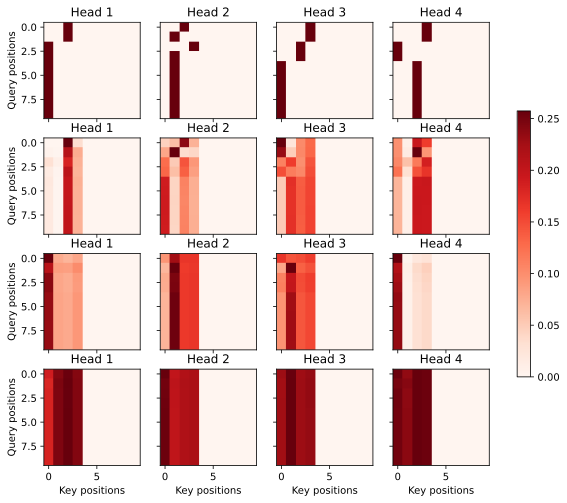

In [47]:
enc_attention_weights_deeper = torch.cat(net_deeper.encoder.attention_weights, 0).reshape((num_layers_deeper, num_heads,
    -1, num_steps))

d2l.show_heatmaps(
    enc_attention_weights_deeper.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(10, 8))


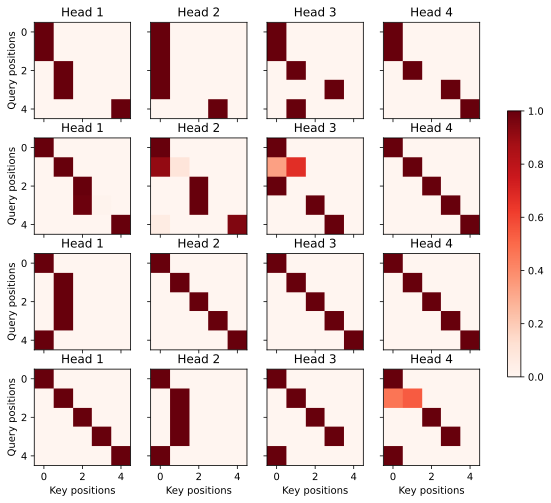

In [48]:
dec_attention_weights_2d_deeper = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled_deeper = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d_deeper).fillna(0.0).values)  # 用零填充被掩蔽住的注意力权重
dec_attention_weights_deeper = dec_attention_weights_filled_deeper.reshape((-1, 2, num_layers_deeper, num_heads, num_steps))
dec_self_attention_weights_deeper, dec_inter_attention_weights_deeper = \
    dec_attention_weights_deeper.permute(1, 2, 3, 0, 4)

d2l.show_heatmaps(  # 逐行呈现解码器的多头自注意力的权重
    dec_self_attention_weights_deeper[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(10, 8))


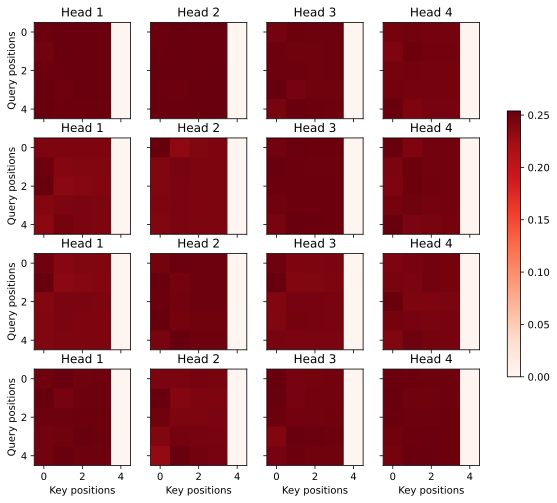

In [50]:
d2l.show_heatmaps(
    dec_inter_attention_weights_deeper[:, :, :, :len(translation.split()) + 1], xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(10, 8))

[参考代码](https://www.cnblogs.com/CLGYPYJ/p/17595653.html)

[参考答案](https://www.cnblogs.com/CLGYPYJ/p/17595653.html)

## Vision Transformer (ViT)

![Vision Transformer](./img/vit.svg)

在这个例子中，一幅图像被分割成九个区块(patch)。一个特殊的`<cls>`标记和九个扁平化的图像区块通过区块嵌入操作和转换器编码块转换成十个部分。而`<cls>`表示则进一步转换为输出标签。

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

### Patch Embedding

我们首先实现区块嵌入，即将图像分割成区块并对这些扁平化后的区块进行线性投影，这里可简化为一次卷积操作，其中内核大小和步长大小均设置为区块的大小。

补充：在普通卷积操作中，卷积层的参数（如卷积核的权重）在模型初始化时就会被创建和初始化。而在LazyConv2d中，这些参数的创建和初始化会被延迟到第一次前向传播时才进行。

这种延迟初始化的方式可以节省内存，特别是在处理大规模数据或者模型时，可以有效地减少内存的使用。

In [17]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512) -> None:
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size, stride=patch_size)

    def forward(self, X):
        # 输出形状：(批量大小，补丁数量，通道数量)
        return self.conv(X).flatten(2).transpose(1, 2)

In [53]:
# Test
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = torch.ones(batch_size, 3, img_size, img_size)
# 输出形状：（批量大小，区块个数，嵌入维度）
patch_emb(X).shape

c:\Users\Jason Chen\.conda\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 36, 512])

### Encoder

ViT 的 MLP 与原始 Transformer 的 PositionWiseFFN 略有不同。
- 首先，这里的激活函数使用的是高斯误差线性单元 (GELU)，它可以被视为 ReLU 的平滑版本；
- 其次，MLP 中每个全连接层的输出都应用了暂退法 (Dropout) ，以实现正则化。

In [18]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5) -> None:
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, X):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(self.dense1(X)))))

ViT 的编码器模块实现采用了前规范化`(pre-normalization)`设计，即在多头注意力或 MLP 之前进行规范化。普通的 Transformer 架构使用的后归一化将归一化放在残差连接之后，与之相比，前归一化能更有效或高效地训练变形。

In [19]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens,
                                                num_heads, dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

In [59]:
X = torch.ones((2, 100, 24))
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X).shape == X.shape

c:\Users\Jason Chen\.conda\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


True

#### Something Achieved in d2l-1.0.3(English version)

In [20]:
from d2l_pytorch_en import Trainer, FashionMNIST, Classifier

### Implementation

In [21]:
class ViT(Classifier):
    """Vision Transformer模型."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.randn(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # 加上<cls>字符
        # 位置嵌入是可学习的
        self.pos_embedding = nn.Parameter(torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), ViTBlock(num_hiddens, num_hiddens, mlp_num_hiddens, 
                                                          num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens), nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

### Train

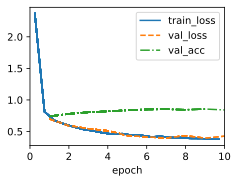

In [22]:
img_size, patch_size, num_classes = 96, 16, 10
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout, lr, num_classes)
trainer = Trainer(max_epochs=10, num_gpus=1)
data = FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)  # 仅 4min 7.4s

### Averaged Patch Representations

In [11]:
class MeanViT(Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        X = X.mean(dim=1, keepdim=True)
        return self.head(X)

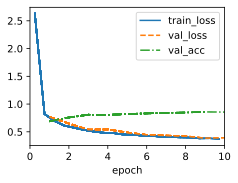

In [14]:
img_size, patch_size, num_classes = 96, 16, 10
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = MeanViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
data = FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)  # 竟然跑了161min 44.3s！

### Hyperparameters Setting

In [ ]:
def experiment(params):
    model = ViT(**params)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    X,y = next(iter(data.get_dataloader(False)))
    y_hat = model(X) 
    return model.loss(y_hat,y)

In [ ]:
import itertools

def parameter_grid(param_dict):
    """Generate a grid of parameters for hyperparameter tuning."""
    keys, values = zip(*param_dict.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        yield params

In [ ]:
param_grid = {'img_size':[32,96,128],
              'patch_size':[8, 16, 32],
              'num_hiddens':[256, 512, 1024],
              'mlp_num_hiddens':[1024, 2048, 4096],
              'num_heads':[4, 8, 16],
              'num_blks':[1, 2, 4],
              'emb_dropout':[0.1,0.5,0.9],
              'blk_dropout':[0.1,0.5,0.9],
              'lr':[0.01,0.1,1]}
param_grid_obj = ParameterGrid(param_grid)
ppls = []
for params in param_grid_obj:
    ppl = experiment(**params)
    ppls.append(ppl)
    print(params, ppl)

[参考答案](https://pandalab.me/archives/transformers_for_vision)